#### This notebook shows how to read the fastMRI dataset and apply some simple transformations to the data.

In [27]:
# Testing if integration works

In [1]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt

Each file corresponds to one MRI scan and contains the k-space data, ground truth and some meta data related to the scan.

# Masked Testing Data

In [74]:
test_data = '../data/singlecoil_test/file1000304.h5'
hf = h5py.File(test_data)
#file_name2 = '../data/singlecoil_test/file1000022.h5'
#file_name3 = '../data/singlecoil_test/file1000055.h5'
#hf2 = h5py.File(file_name2)
#hf3 = h5py.File(file_name3)

In [75]:
print('Keys:', list(hf.keys()))
print('Attrs:', dict(hf.attrs))

Keys: ['ismrmrd_header', 'kspace', 'mask']
Attrs: {'acceleration': 8, 'acquisition': 'CORPD_FBK', 'num_low_frequency': 15, 'patient_id': '5994c7cbe49fe8be6b304dab9f7ba0b62a4b50298a5eaf8c2d03bac9b3e42929'}


In multi-coil MRIs, k-space has the following shape:
(number of slices, number of coils, height, width)

For single-coil MRIs, k-space has the following shape:
(number of slices, height, width)

MRIs are acquired as 3D volumes, the first dimension is the number of 2D slices.

In [76]:
volume_kspace = hf['kspace'][()]
#volume_kspace2 = hf2['kspace'][()]
#volume_kspace3 = hf3['kspace'][()]
print(volume_kspace.dtype)
print(volume_kspace.shape)

complex64
(36, 640, 372)


In [77]:
slice_kspace = volume_kspace

Let's see what the absolute value of k-space looks like:

In [78]:
def show_multiple_slices(data, slice_nums, cmap=None):
    fig = plt.figure()
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)

In [79]:
#def show_slice(data, cmap=None):
    #fig = plt.figure()
    #plt.imshow(data, cmap=cmap)

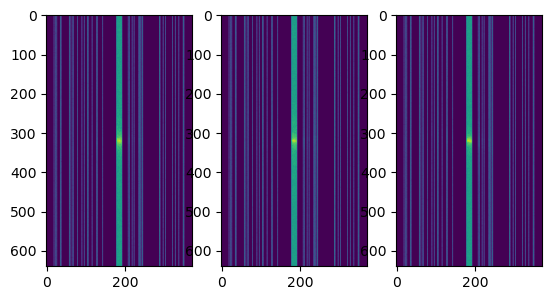

In [80]:
show_multiple_slices(np.log(np.abs(slice_kspace) + 1e-9), [10,20,30]) #show the 10th, 20th, and 30th slices

The fastMRI repo contains some utlity functions to convert k-space into image space. These functions work on PyTorch Tensors. The to_tensor function can convert Numpy arrays to PyTorch Tensors.

In [81]:
import fastmri
from fastmri.data import transforms as T

In [82]:
slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image

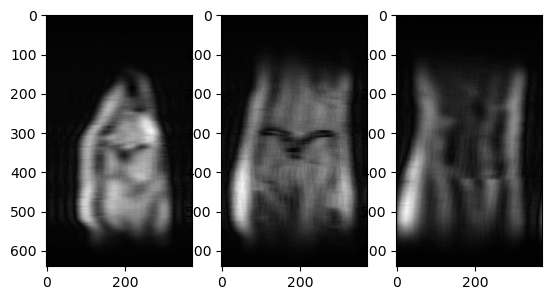

In [83]:
show_multiple_slices(slice_image_abs, [10,20,30], cmap='gray')

MR imaging is an indirect process, whereby cross-sectional images of the subject’s anatomy are
produced from frequency and phase measurements instead of direct, spatially-resolved measurements. As we can see, each image in the dataset focuses on a different snapshot of the subject's anatomy. These slices can be combined into the full image using the Root-Sum-of-Squares (RSS) transform.

In [84]:
slice_image_rss = fastmri.rss(slice_image_abs, dim=0)

# Before Reconstruction

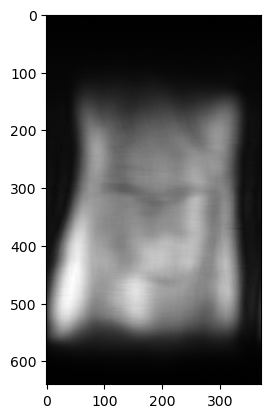

In [85]:
plt.imshow(np.abs(slice_image_rss.numpy()), cmap='gray')

# After Reconstruction

In [86]:
reconstructed = 'fastmri_examples/unet/output/reconstructions/file1000304.h5'
hf_r = h5py.File(reconstructed)

In [87]:
print('Keys:', list(hf_r.keys()))
print('Attrs:', dict(hf_r.attrs))

Keys: ['reconstruction']
Attrs: {}


In [88]:
volume_kspace_r = hf_r['reconstruction'][()]
print(volume_kspace_r.dtype)
print(volume_kspace_r.shape)

float32
(1, 1, 320, 320)


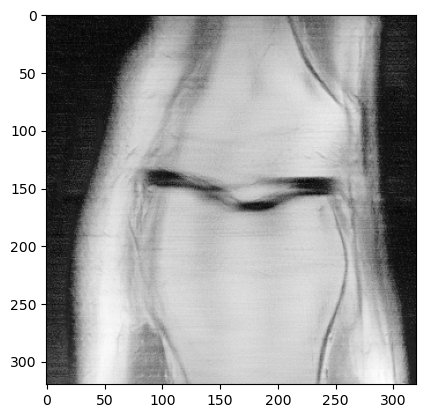

In [89]:
fig = plt.figure()
plt.imshow(np.log(np.abs(volume_kspace_r[0][0]) + 1e-9), cmap="gray")

#show_multiple_slices(np.log(np.abs(volume_kspace_r) + 1e-9)) #show the 10th, 20th, and 30th slices

# Simulating Under-Sampled Data

So far, we have been looking at fully-sampled data. We can simulate under-sampled data by creating a mask and applying it to k-space.

In [147]:
from fastmri.data.subsample import RandomMaskFunc
mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[8])  # Create the mask function object

In [148]:
masked_kspace, mask, _ = T.apply_mask(slice_kspace2, mask_func)   # Apply the mask to k-space

Let's see what the subsampled image looks like:

In [149]:
sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)

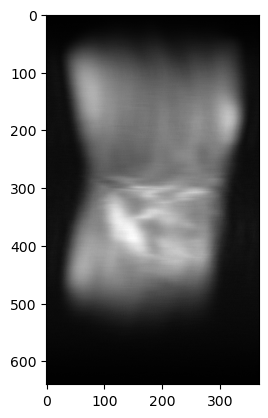

In [150]:
plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')